# Detecting Insults in Social Commentary

Because this dataset is far too small to use a neural network (which was my last approach to NLP), I'm going to experiment with some machine learning algorithms from scikit-learn to identify insults in social commentary.

When this competition ran on Kaggle 5 years ago, the best AUC ROC score was 0.84249 on the private test set (which I also have access to, and will be using as my test set). Let's see if, using all of the new tools available (i.e. GloVe vectrs), I can better this score.

## XGBoost

In [24]:
% matplotlib inline

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import roc_auc_score

from tqdm import *

Loading the data

In [106]:
glove_comments = np.load('glove_array.npy')
data = pd.read_csv('train.csv')

In [107]:
y_labels = np.asarray(data.Insult)

Making a training and validation set

In [108]:
msk = np.random.rand(len(data)) < 0.8

glove_train = glove_comments[msk]
glove_valid = glove_comments[~msk]

labels_train = y_labels[msk]
labels_valid = y_labels[~msk]

Training with XGBoost

In [304]:
param = {'max_depth':3, 'eta':0.2, 'silent':1, 'objective':'binary:logistic',}
num_round = 7

In order to train the data, I need to make it a data matrix, which is the data type used by XGBoost. 

In [305]:
train_data = xgb.DMatrix(glove_train, label = labels_train)

In [306]:
bst = xgb.train(param, train_data, num_round)

In [307]:
test_data = xgb.DMatrix(glove_valid)

In [308]:
preds = bst.predict(test_data)

In [309]:
roc_auc_score(labels_valid, preds)

0.82056358667017915

This is less good than the SVC classifier from sklearn. Lets peak under the hood to see what's up. 

In [312]:
def auc_vs_m_xgb(X_train, Y_train, X_cv, Y_cv, param, num_round, plot=True):
    error_cv = []
    error_train = []
    valid_data = xgb.DMatrix(glove_valid)
    
    for m in tqdm(range(10, len(X_train)-1, 100)):
        
        train_data = xgb.DMatrix(X_train[:m,:], Y_train[:m])
        bst = xgb.train(param, train_data, num_round)
        predicted_cv = bst.predict(valid_data)
        error_cv.append(roc_auc_score(Y_cv, predicted_cv))
        
        train_test_data = xgb.DMatrix(X_train[:m,:])
        
        predicted_train = bst.predict(train_test_data)
        error_train.append(roc_auc_score(Y_train[:m], predicted_train))

    if plot: 
        m = range(10, len(X_train)-1, 100)
        plt.plot(m, error_cv, label = 'cv')
        plt.plot(m, error_train, label = 'train')
        plt.xlabel("Training set size")
        plt.ylabel("AUC ROC score")
        plt.legend()
        plt.show()
    
    return error_cv, error_train

100%|██████████| 32/32 [00:14<00:00,  1.36it/s]


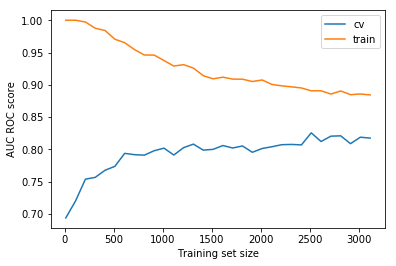

In [313]:
error_cv, error_train = auc_vs_m_xgb(glove_train, labels_train, glove_valid, labels_valid, param, num_round, plot=True)

In [314]:
error_cv[-1]

0.81756701132771348